# Josephson Juction data example
From https://www.itl.nist.gov/div898/handbook/eda/section4/eda424.htm

One interesting thing about this data is that it is discrete (presumably because of rounding).

The strategy here is to treat this just like the Normal Random Data example, but then add a model that includes the rounding effect.

In [1]:
import numpy as np
import scipy.stats as st
import pymc3 as pm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# suppress some warnings from pymc3 output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# set random seed for reproducibility
np.random.seed(123)

The data is downloaded from https://www.itl.nist.gov/div898/handbook/datasets/SOULEN.DAT

In [5]:
filename='SOULEN.DAT'
data=(np.loadtxt(filename,skiprows=25)).flatten()

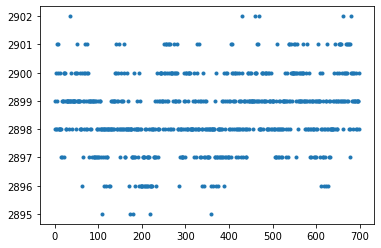

In [6]:
plt.plot(data,'.')

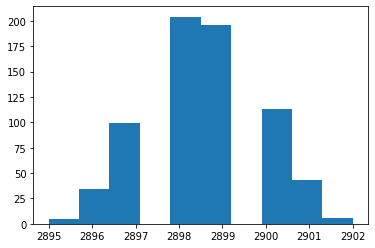

In [7]:
plt.hist(data);

In [8]:
print('Sample mean: {}, Sample std: {}'.format(data.mean(), data.std(ddof=1)))

Sample mean: 2898.5614285714287, Sample std: 1.30496935730421


## MCMC

It seems that the flat priors cause the sampler to fail, so I'll use weakly informative priors.

In [9]:
with pm.Model() as model1:
    #logs = pm.Flat('logs')
    logs = pm.Normal('logs',mu=np.log(data.std(ddof=1)),sigma=10*np.log(data.std(ddof=1)))
    s = pm.Deterministic('s',pm.math.exp(logs))
    s2 = pm.Deterministic('s2',s*s)
    #mu = pm.Flat('mu')
    mu = pm.Normal('mu',mu=data.mean(),sigma=10*data.std(ddof=1))
    yobs = pm.Normal('yobs',mu=mu,sigma=s,observed=data)

In [10]:
model1.name='Unknown mean and var'

In [11]:
with model1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, logs]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2596.00draws/s]


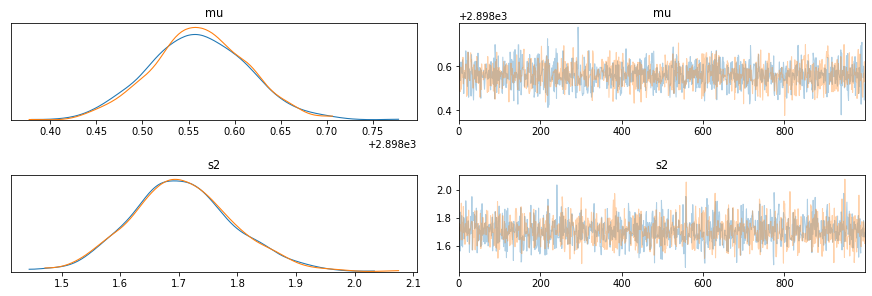

In [12]:
pm.traceplot(trace1,var_names=['mu','s2']);

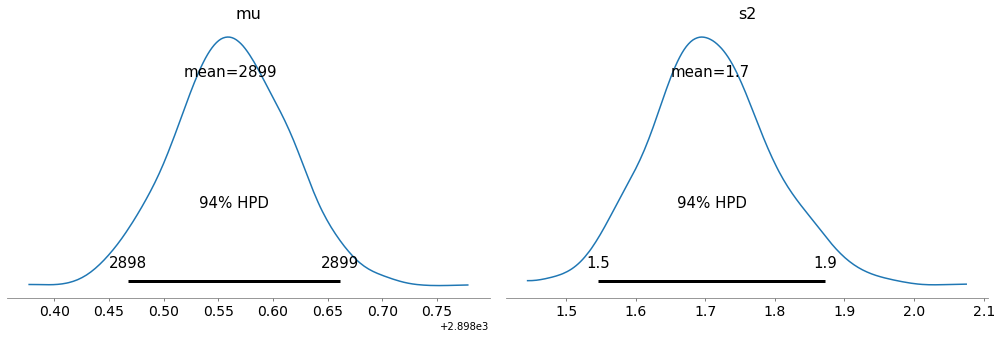

In [13]:
pm.plot_posterior(trace1,var_names=['mu','s2']);

In [14]:
import corner

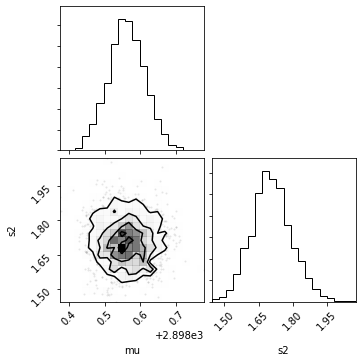

In [15]:
corner.corner(np.vstack([trace1['mu'],trace1['s2']]).T,labels=['mu','s2']);

In [16]:
np.quantile(trace1['mu'],[0.025,0.5,0.9725])

array([2898.46005695, 2898.56101567, 2898.66047461])

In [17]:
np.quantile(trace1['s2'],[0.025,0.5,0.9725])

array([1.54374551, 1.70267469, 1.88472165])

## MCMC with latent rounding model

FIXME - this doesn't work currently

I think the correct fix is to write a new DiscreteNormal model class.  Help documents also talk about using pm.Potential, but I don't understand how it works.

In [126]:
# write log-likelihood for rounded normal
def RNlogp(mu, sigma):
    
    def logp_(x):
        #reshape
        #x = np.asarray(x).reshape([1,-1])
        #mu = np.asarray(mu).reshape([-1,1])
        #sigma = np.asarray(sigma).reshape([-1,1])
        return np.log(st.norm.cdf((x+0.5-mu)/sigma)-st.norm.cdf((x-0.5-mu)/sigma)).sum(axis=1)
    
    return logp_

In [127]:
with pm.Model() as model2:
    #logs = pm.Flat('logs')
    logs = pm.Normal('logs',mu=np.log(data.std(ddof=1)),sigma=10*np.log(data.std(ddof=1)))
    s = pm.Deterministic('s',pm.math.exp(logs))
    s2 = pm.Deterministic('s2',s*s)
    #mu = pm.Flat('mu')
    mu = pm.Normal('mu',mu=data.mean(),sigma=10*data.std(ddof=1))
    yobs = pm.DensityDist('yobs',RNlogp(mu,s),observed=data)
    #yobs = pm.Potential('yobs', RNlogp(mu,s,data))

TypeError: Variables do not support boolean operations.

In [52]:
model2.name='Rounded'

In [53]:
with model2:
    trace2=pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [yround, mu, logs]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 378.42draws/s]


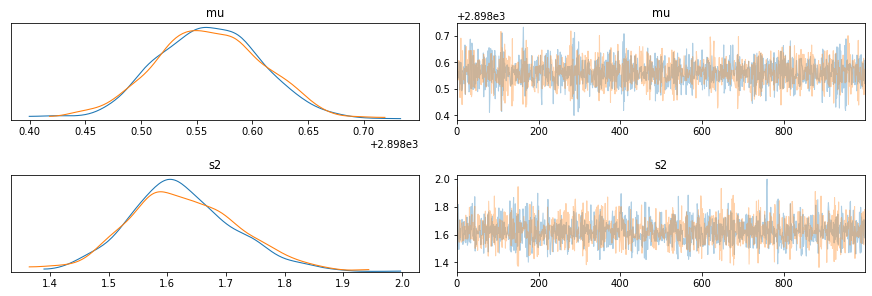

In [54]:
pm.traceplot(trace2,var_names=['mu','s2']);

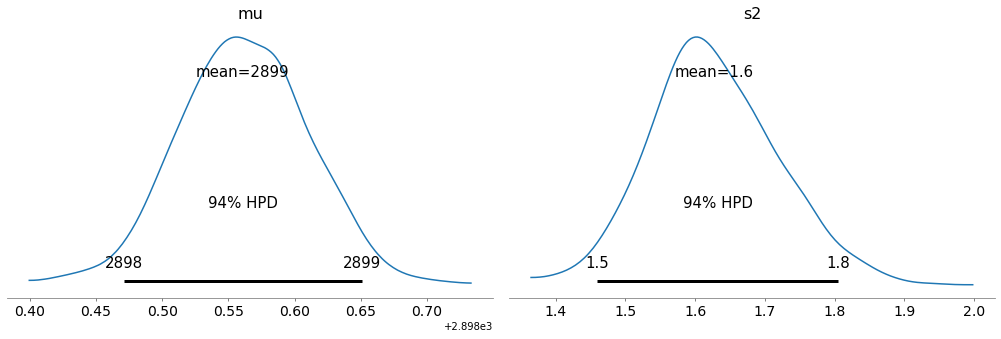

In [55]:
pm.plot_posterior(trace2,var_names=['mu','s2']);

In [56]:
np.quantile(trace2['mu'],[0.025,0.5,0.975])

array([2898.46522685, 2898.56014909, 2898.65585837])

In [57]:
np.quantile(trace2['s2'],[0.025,0.5,0.975])

array([1.45845294, 1.62021159, 1.8237624 ])

In [58]:
models={model1: trace1, model2:trace2}
pm.compare(models)

/home/corcoted/anaconda3/envs/pymc/lib/python3.7/site-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Unknown mean and var,2362.1,1.92,0,1,35.88,0,0
Rounded,2362.3,34.64,0.2,0,35.8,0.3,0


In [59]:
with model2:
    map2=pm.find_MAP()

logp = -954.23, ||grad|| = 0.3465: 100%|██████████| 60/60 [00:00<00:00, 1617.17it/s]  


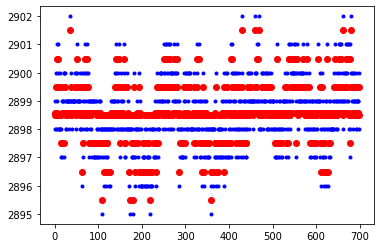

In [68]:
plt.plot(-map2['yround']+data,'ro')
plt.plot(data,'b.')

In [69]:
help(pm.Potential)

Help on function Potential in module pymc3.model:

Potential(name, var, model=None)
    Add an arbitrary factor potential to the model likelihood
    
    Parameters
    ----------
    name : str
    var : theano variables
    
    Returns
    -------
    var : var, with name attribute

